# EDA & Unsupervised Anomaly Detection on Corrupted EMNIST

Project rules reminder:
- Single pre-run notebook for submission.
- Use the provided corrupted EMNIST only (no clean MNIST/EMNIST for assistance).
- Document what you try and what you observe; cite any external code if reused.

Scope of this notebook (Part A):
- Load the provided corrupted EMNIST (`.npz`).
- EDA: shape, stats, sample grids, intensity histograms.
- Unsupervised anomaly detection with two methods: (1) reconstruction error (ConvAE), (2) IsolationForest on latent embeddings.
- Visualize top anomalies; describe corruption patterns; outline simple recovery options.

Fill in paths/links as needed for your dataset location.



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import IsolationForest

# Plot defaults
sns.set_context("talk")
plt.rcParams.update({"figure.figsize": (10, 6)})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cpu


In [15]:
# Ensure working directory at project root and set data path
import os
ROOT = Path("/home/alcyenna/deeplearning_project")
os.chdir(ROOT)
DATA_PATH = ROOT / "data/all_imagesfinal.npz"
print("CWD:", Path.cwd())
print("DATA_PATH exists:", DATA_PATH.exists())



CWD: /home/alcyenna/deeplearning_project
DATA_PATH exists: True


In [16]:
# Load corrupted EMNIST
assert DATA_PATH.exists(), f"File not found: {DATA_PATH}"

data = np.load(DATA_PATH)
print("Available keys in .npz:", data.files)

# Try common key names
if "images" in data.files:
    imgs = data["images"]
elif "x" in data.files:
    imgs = data["x"]
elif "data" in data.files:
    imgs = data["data"]
elif "X" in data.files:
    imgs = data["X"]
else:
    # Use first available array
    key = data.files[0]
    print(f"Using key: {key}")
    imgs = data[key]

# Try to get labels if available
labels = None
if "labels" in data.files:
    labels = data["labels"]
elif "y" in data.files:
    labels = data["y"]
elif "Y" in data.files:
    labels = data["Y"]

print("images shape:", imgs.shape, "dtype:", imgs.dtype, "min/max:", imgs.min(), imgs.max())
if imgs.max() > 1.0:
    imgs = imgs.astype(np.float32) / 255.0
else:
    imgs = imgs.astype(np.float32)

H, W = imgs.shape[1], imgs.shape[2]
print(f"Normalized to [0,1], HxW={H}x{W}")



Available keys in .npz: ['all_imagesfinal']
Using key: all_imagesfinal
images shape: (131057, 32, 32) dtype: float64 min/max: 0.0 255.0
Normalized to [0,1], HxW=32x32


n_samples: 131057
mean: 0.13424663 std: 0.30083367
% zeros: 0.7432020722614969 % ones: 0.005114857585821436


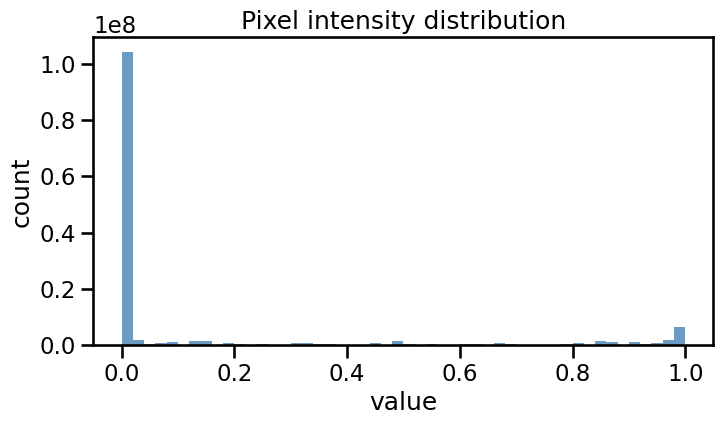

In [17]:
# Basic stats
n_samples = imgs.shape[0]
print("n_samples:", n_samples)
print("mean:", imgs.mean(), "std:", imgs.std())
print("% zeros:", (imgs == 0).mean(), "% ones:", (imgs == 1).mean())

# Intensity histogram
plt.figure(figsize=(8,4))
plt.hist(imgs.flatten(), bins=50, color="steelblue", alpha=0.8)
plt.title("Pixel intensity distribution")
plt.xlabel("value")
plt.ylabel("count")
plt.show()

if labels is not None:
    plt.figure(figsize=(8,4))
    sns.countplot(x=labels)
    plt.title("Label distribution (for inspection only)")
    plt.show()



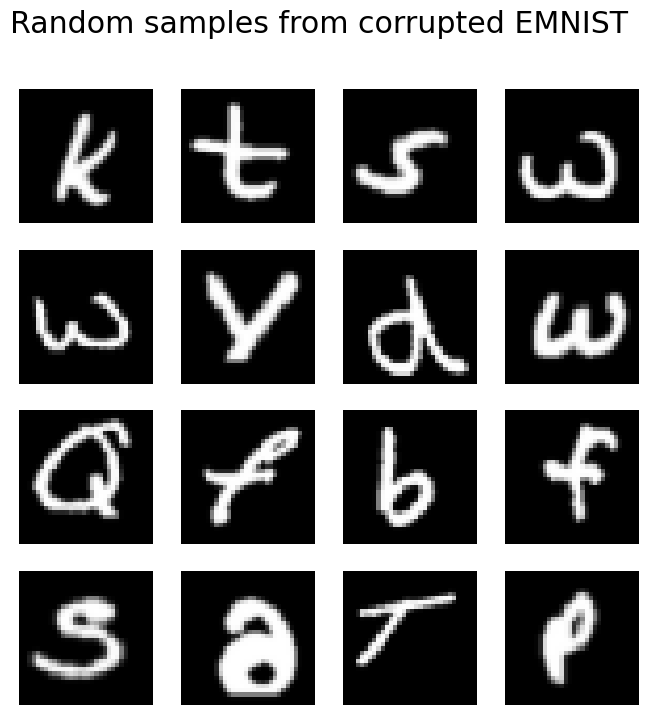

In [18]:
# Visualize random samples
rng = np.random.default_rng(42)
idx = rng.choice(n_samples, size=min(16, n_samples), replace=False)
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for ax, i in zip(axes.flat, idx):
    ax.imshow(imgs[i], cmap="gray")
    ax.axis("off")
plt.suptitle("Random samples from corrupted EMNIST")
plt.show()



In [19]:
# DataLoader setup
x_tensor = torch.from_numpy(imgs[:, None, :, :]).float()
dataset = TensorDataset(x_tensor)
loader = DataLoader(dataset, batch_size=256, shuffle=True)



In [20]:
# Convolutional Autoencoder - adaptive to image size
class ConvAE(nn.Module):
    def __init__(self, input_size, latent=64):
        super().__init__()
        # Calculate dimensions after convolutions
        # Conv: (H, W) -> (H//2, W//2) with kernel 4, stride 2, padding 1
        h1, w1 = input_size[0] // 2, input_size[1] // 2
        h2, w2 = h1 // 2, w1 // 2
        self.enc_dim = 64 * h2 * w2
        
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.enc_dim, latent),
        )
        self.dec = nn.Sequential(
            nn.Linear(latent, self.enc_dim), nn.ReLU(),
            nn.Unflatten(1, (64, h2, w2)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid(),
        )
        self.h2, self.w2 = h2, w2
    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat, z

# Create AE with correct input size
latent_dim = 64
ae = ConvAE((H, W), latent=latent_dim).to(device)
print(f"AE created for {H}x{W} images, latent dim: {latent_dim}, encoder output: {ae.enc_dim}")
opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.MSELoss()



AE created for 32x32 images, latent dim: 64, encoder output: 4096


In [21]:
# Train AE (short run; adjust epochs as needed)
num_epochs = 8
for epoch in range(num_epochs):
    for (batch,) in loader:
        batch = batch.to(device)
        opt.zero_grad()
        recon, _ = ae(batch)
        loss = crit(recon, batch)
        loss.backward()
        opt.step()
    print(f"epoch {epoch+1}/{num_epochs} - loss {loss.item():.4f}")



epoch 1/8 - loss 0.0064
epoch 2/8 - loss 0.0057
epoch 3/8 - loss 0.0044
epoch 4/8 - loss 0.0048
epoch 5/8 - loss 0.0042
epoch 6/8 - loss 0.0043
epoch 7/8 - loss 0.0047
epoch 8/8 - loss 0.0041


In [22]:
# Embeddings and scores
from torch.utils.data import DataLoader

score_loader = DataLoader(dataset, batch_size=512, shuffle=False)
embeds = []
recon_err = []

ae.eval()
with torch.no_grad():
    for (batch,) in score_loader:
        batch = batch.to(device)
        recon, z = ae(batch)
        embeds.append(z.cpu().numpy())
        err = ((recon - batch) ** 2).flatten(1).mean(1).cpu().numpy()
        recon_err.append(err)

embeds = np.concatenate(embeds)
recon_err = np.concatenate(recon_err)

iso = IsolationForest(n_estimators=200, contamination="auto", random_state=42, n_jobs=-1)
iso.fit(embeds)
iso_score = -iso.decision_function(embeds)  # higher = more anomalous

combined = 0.5 * recon_err + 0.5 * iso_score
print("score stats -> recon mean/std:", recon_err.mean(), recon_err.std(), "iso mean/std:", iso_score.mean(), iso_score.std())



score stats -> recon mean/std: 0.0044612214 0.006699058 iso mean/std: -0.06451849762649195 0.021024684855680643


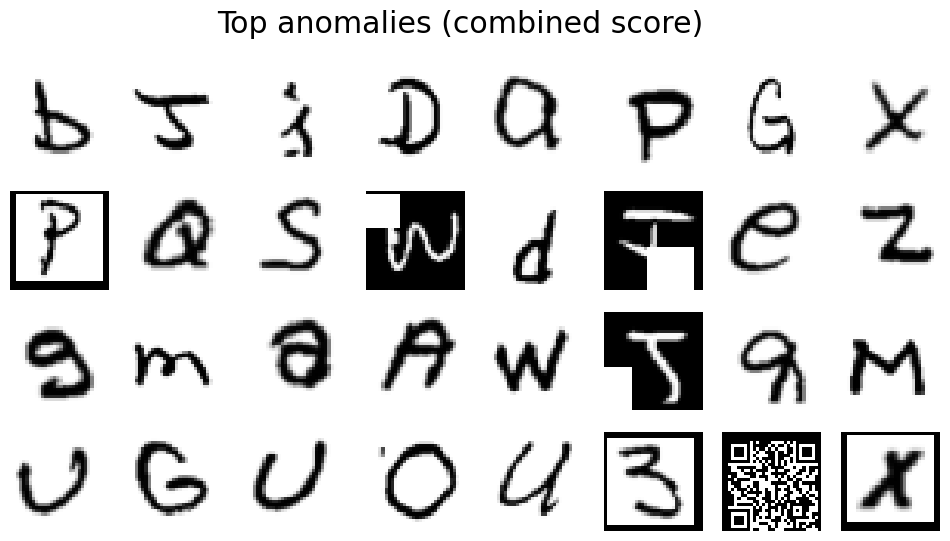

In [23]:
# Top anomalies visualization
k = min(32, n_samples)
top_idx = np.argsort(combined)[-k:]
fig, axes = plt.subplots(4, 8, figsize=(12,6))
for ax, i in zip(axes.flat, top_idx):
    ax.imshow(imgs[i], cmap="gray")
    ax.axis("off")
plt.suptitle("Top anomalies (combined score)")
plt.show()

